In [ ]:
!pip install parameter-sherpa pandas numpy

In [39]:
%display typeset

In [40]:
var('S E I A H Lambda beta chi alpha p phi delta rho mu gamma')

(S, E, I, A, H, Lambda, beta, chi, alpha, p, phi, delta, rho, mu, gamma)

In [41]:
Lambda = beta*(I+A)
dsdt = -Lambda*(1-chi)*S
dedt = Lambda*(1-chi)*S - alpha*E
didt = (1-p)*alpha*E - (delta + phi)*I
dadt = p*alpha*E - gamma*A
dhdt = phi*I-(rho+mu)*H

In [42]:
solve([dsdt,dedt,didt,dadt,dhdt],[S,E,I,A,H])

[[S == r2, E == 0, I == 0, A == 0, H == 0]]

In [43]:
jack=jacobian([dsdt,dedt,didt,dadt,dhdt],[S,E,I,A,H])
jack

[ (A + I)*beta*(chi - 1)                       0        S*beta*(chi - 1)        S*beta*(chi - 1)                       0]
[-(A + I)*beta*(chi - 1)                  -alpha       -S*beta*(chi - 1)       -S*beta*(chi - 1)                       0]
[                      0          -alpha*(p - 1)            -delta - phi                       0                       0]
[                      0                 alpha*p                       0                  -gamma                       0]
[                      0                       0                     phi                       0               -mu - rho]

## R0

In [44]:
F_cal = matrix([[Lambda*(1-chi)*S],[0],[0]])
F_cal

[-(A + I)*S*beta*(chi - 1)]
[                        0]
[                        0]

In [45]:
V_cal_neg = matrix([[alpha*E],[delta*I],[delta*A]])
V_cal_neg

[E*alpha]
[I*delta]
[A*delta]

In [46]:
V_cal_pos = matrix([[0],[(1-p)*alpha*E],[p*alpha*E]])
V_cal_pos

[               0]
[-E*alpha*(p - 1)]
[       E*alpha*p]

In [47]:
V_cal = V_cal_neg-V_cal_pos
V_cal

[                  E*alpha]
[E*alpha*(p - 1) + I*delta]
[     -E*alpha*p + A*delta]

In [48]:
F = jacobian(F_cal(S=1),[E,I,A])
F

[              0 -beta*(chi - 1) -beta*(chi - 1)]
[              0               0               0]
[              0               0               0]

In [49]:
V = jacobian(V_cal(S=1),[E,I,A])
V

[        alpha             0             0]
[alpha*(p - 1)         delta             0]
[     -alpha*p             0         delta]

In [50]:
M = F*V.inverse()
M=M.simplify_full()
M

[-(beta*chi - beta)/delta -(beta*chi - beta)/delta -(beta*chi - beta)/delta]
[                       0                        0                        0]
[                       0                        0                        0]

In [51]:
M.eigenvalues()

[-(beta*chi - beta)/delta, 0, 0]

In [52]:
R0=M[0,0].simplify_full()
R0

-(beta*chi - beta)/delta

In [53]:
R0.variables()

(beta, chi, delta)

In [54]:
Ft = jacobian(F_cal,[E,I,A])
Vt = jacobian(V_cal,[E,I,A])
Mt = Ft*Vt.inverse()
show(pretty_print(html('$R_t=$')))
Rt = Mt[0,0]
Rt

<script type="math/tex">R_t=</script>

None

S*beta*(chi - 1)*(p - 1)/delta - S*beta*(chi - 1)*p/delta

In [55]:
print(Rt)

S*beta*(chi - 1)*(p - 1)/delta - S*beta*(chi - 1)*p/delta


In [56]:
R0(chi=0.1,phi=.1,rho=.6,delta=.1,alpha=10, p=.75,beta=.5)

4.50000000000000

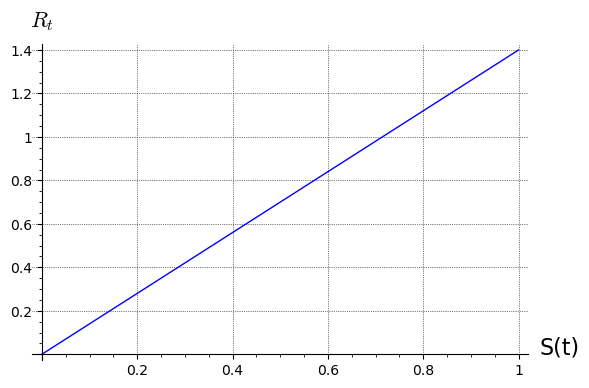

In [57]:
P = plot(Rt(chi=0.3,phi=.1,rho=.6,delta=.1,alpha=10,beta=.2, p=.75),(S,0,1))
P.show(axes_labels=['S(t)','$R_t$'], gridlines=True)

Modelo do Flávio:

In [58]:
import numpy as np
import pandas as pd
%display typeset

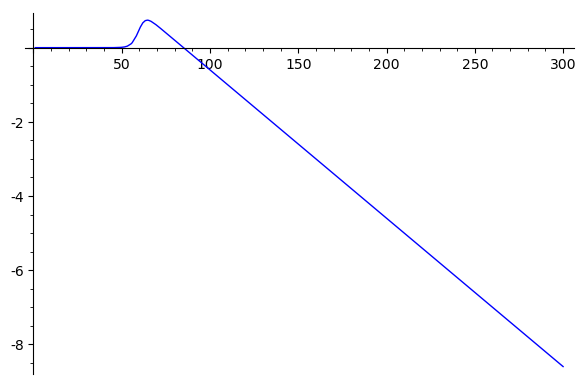

In [59]:
var("T Q R")
Q = 60
R = 0.04
eq = ((1 + np.tanh((T - Q)/4)) / 2) * ((T - Q) * -R + 1)
plot(eq, (T,1,300))

In [60]:
def model(t, y, params):
    S, E, I, A, H, R, D, C = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    
    chi *= ((1 + np.tanh((t - q)/4)) / 2) * ((t - q) * -r + 1)
    if (chi < 0):
        chi = 0
    
    return [
        -lamb * ((1 - chi) * S),                   # 0 dS/dt
        lamb * ((1 - chi) * S) - alpha * E,        # 1 dE/dt
        (1 - p) * alpha * E - delta * I - phi * I, # 2 dI/dt
        p * alpha * E - gamma * A,                 # 3 dA/dt
        phi * I - (rho + mu) * H,                  # 4 dH/dt
        delta * I + rho * H + gamma * A,           # 5 dR/dt
        phi * I,                                   # 6 Hospit. acumuladas
        mu * H,                                    # 7 Morte acumuladas
    ]

In [61]:
Total_Pop = 14810000

chi   = 0.900
phi   = 0.013
beta  = 0.273
rho   = 0.219
delta = 0.042
gamma = 0.040
alpha = 0.341
mu    = 0.024
p     = 0.769
q     = 30
r     = 0.004

In [62]:
O = ode_solver()
O.function = model
O.algorithm = 'rk8pd'
inits = [.99, 0, 1e-3, 0, 0, 0, 0, 0]
tspan = [0, 300]
O.ode_solve(tspan, inits, num_points=300, params=[chi,phi,beta,rho,delta,gamma,alpha,mu,p,q,r])

In [63]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

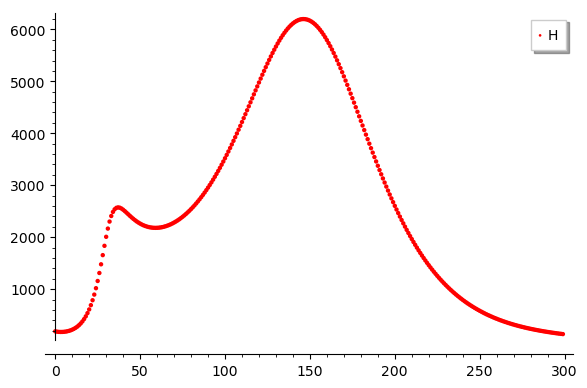

In [64]:
def plot_I(sol):
    sim = get_sim_array(sol)*Total_Pop
    dif = np.diff(sim[:,6]) + [0]
    P = list_plot(dif,color='red',legend_label='H')
    #P += list_plot(sim[:,2],color='blue',legend_label='I')
    show(P)

plot_I(O.solution)

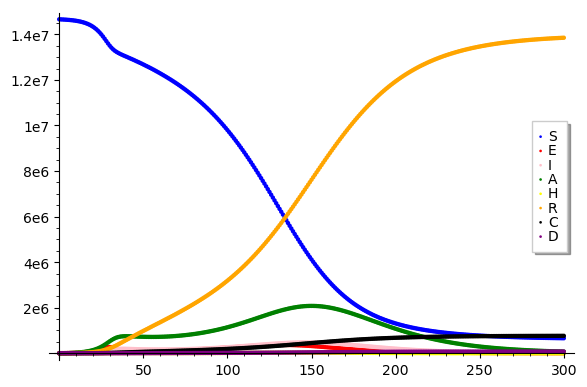

In [66]:
#eq = ((1 + np.tanh((T - q)/4)) / 2) * ((T - q) * r + 1)

def plot_sol(sol):
    sim = get_sim_array(sol)*Total_Pop
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','pink','green','yellow','orange','black','purple']
    for i,var in enumerate(['E','I','A','H','R','C','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
    
    show(P)

plot_sol(O.solution)

***

In [ ]:
import sherpa

In [317]:
popCA = 14810000
dfCA = pd.read_pickle("data.pkl")
ld = len(dfCA)
html(dfCA.tail().to_html())

,cases,deaths,mov
date,,,
2020-11-15,2567.166667,48.5,16.339835
2020-11-16,2539.600000,51.2,16.110790
2020-11-17,2616.750000,55.0,15.884496
2020-11-18,2623.666667,51.0,15.695077
2020-11-19,2727.000000,45.5,15.552320


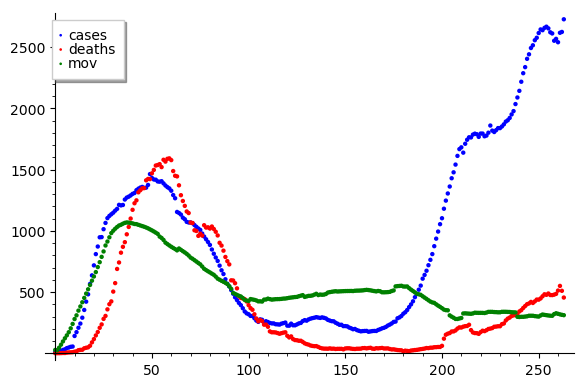

In [318]:
a = list_plot(dfCA["cases"],     color='blue',  legend_label="cases")
b = list_plot(dfCA["deaths"]*10, color='red',   legend_label="deaths")
c = list_plot(dfCA["mov"]*20,    color='green', legend_label="mov")
show(a+b+c)

In [347]:
# S, E, I, A, H, R, D, C = y
# chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params

parameters = [
    sherpa.Continuous(name='chi',  range=[0,.7]),
    sherpa.Continuous(name='phi',  range=[0,1]),
    sherpa.Continuous(name='beta', range=[0.1,2]),
    sherpa.Continuous(name='rho',  range=[0.2,1]),
    sherpa.Continuous(name='delta',range=[0.01,1]),
    sherpa.Continuous(name='gamma',range=[0.01,1]),
    sherpa.Continuous(name='alpha',range=[0.01,1]),
    sherpa.Continuous(name='mu',   range=[0.01,.7]),
    sherpa.Continuous(name='p',    range=[0.01,.7]),
    sherpa.Discrete  (name='q',    range=[0,30]),
    sherpa.Continuous(name='r',    range=[0,0.01]),
    sherpa.Discrete  (name='t0',    range=[0,20]),
]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=100)
#algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)
#algorithm = sherpa.algorithms.GPyOpt(model_type='GP',max_num_trials=150)


study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

trial = study.get_suggestion()
trial.parameters

{'chi': 0.24171142305297183,
 'phi': 0.9735936458696939,
 'beta': 1.820095895406787,
 'rho': 0.7627282669579605,
 'delta': 0.7473590647818031,
 'gamma': 0.5138513398028701,
 'alpha': 0.11332544918505295,
 'mu': 0.041307118509386974,
 'p': 0.44534724160252576,
 'q': 11,
 'r': 0.00044314345184878534}

In [348]:
i = 0

for trial in study:
    i += 1
    print(f"{i} ", end="")
    
    pars = [trial.parameters[n] for n in ['chi', 'phi', 'beta', 'rho', 'delta', 'gamma', 'alpha', 'mu', 'p', 'q', 'r']]
    t0 = trial.parameters['t0']
    O.ode_solve(tspan, inits, num_points=ld+t0+1, params=pars)
    sim = get_sim_array(O.solution)
    H = sim[t0 : ld + t0, 6] * popCA
    M = sim[t0 : ld + t0, 7] * popCA
    
    #loss = sum((dfCA.cases - H)**2)
    
    loss = sum((dfCA.cases-H)**2) + sum((dfCA.deaths-M)**2)/2*ld
    study.add_observation(trial=trial, objective=loss)
    study.finalize(trial)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [349]:
res = study.get_best_result()
res

{'Trial-ID': 25,
 'Iteration': 1,
 'alpha': 0.3892192215094547,
 'beta': 0.458364431991236,
 'chi': 0.6120757787141151,
 'delta': 0.7498496035143021,
 'gamma': 0.49174689127630483,
 'mu': 0.02620684047375093,
 'p': 0.23788552346709263,
 'phi': 0.047784400961836226,
 'q': 12,
 'r': 0.007637539293174705,
 'rho': 0.675367819231866,
 'Objective': 405930406.01299894}

In [350]:
def plot_results(pars):
    t0 = pars[-1]
    O.ode_solve(tspan, inits, num_points=t0+ld, params=list(pars[:-1]))
    sim = get_sim_array(O.solution)*popCA
    h   = list_plot(sim[:ld+t0,-2],color='red',legend_label='Cum. cases', plotjoined=True)
    d   = list_plot(sim[:ld+t0,-1],color='purple', legend_label='Cum. Deaths', plotjoined=True)
    cc  = list_plot(list(zip(range(t0,ld+t0),dfCA.cases)), color='black',legend_label='cases (obs)')
    cd  = list_plot(list(zip(range(t0,ld+t0),dfCA.deaths)), color='orange',legend_label='deaths(obs)')
    show(h + d + cc + cd)

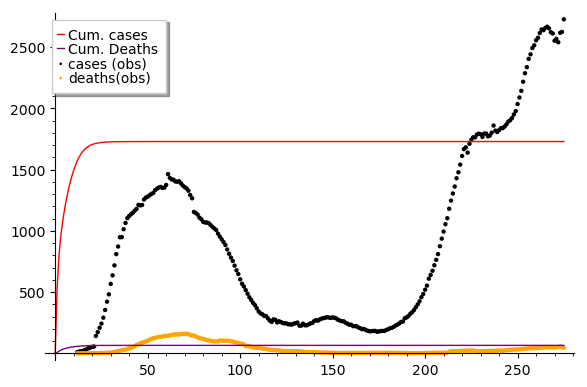

In [351]:
plot_results([res['chi'],
              res['phi'],
              res['beta'],
              res['rho'],
              res['delta'],
              res['gamma'],
              res['alpha'],
              res['mu'],
              res['p'],
              res['q'],
              res['r'],
              res['q']
             ])

In [352]:
print(res['q'])

12
